In [17]:
import numpy as np
import scipy
import scipy as sp
import scipy.sparse as sps
import queue
import scipy.constants as spc
import matplotlib.pyplot as plt

In [18]:
a    = 5.431
hbar  = spc.hbar
 
sqrt3 = np.sqrt(3)

# params from (Phys. Rev. B 69 115201 (2004)

# two-centre Slater–Koster integrals
V = {
    'ss_sigma'      : -1.95933,
    's_star_s_star' : -4.24135,
    'ss_star_sigma' : -1.52230,
    'sp_sigma'      :  3.02562,
    's_star_p_sigma':  3.15565,
    'sd_sigma'      : -2.28485,
    's_star_d_sigma': -0.80993,
    'pp_sigma'      :  4.10364,
    'pp_pi'         : -1.51801,
    'pd_sigma'      : -1.35554,
    'pd_pi'         :  2.38479,
    'dd_sigma'      : -1.68136,
    'dd_pi'         :  2.58880,
    'dd_delta'      : -1.81400,
    
    'h_si_ss': -3.999720,
    'h_si_sp': 4.251750,
    'h_si_ss*': -1.697700,
    'h_si_sd': -2.105520,

    # atomic spin-orbit coupling (p-manifold)
    'SOC'           :  0.01989
}

# on-site energies 

E = {
    's'   : -2.15168,
    'px'  :  4.22925, 'py' : 4.22925, 'pz' : 4.22925,
    'dxy' : 13.78950, 'dyz': 13.78950, 'dzx': 13.78950,
    'dx2y2':13.78950, 'dz2': 13.78950,
    's*'  : 19.11650, 'HS' : 0.999840, 'delta_Si' : -0.276789, 'sp3': 25
}



H_SK = {
        ('s',  's')      : lambda l,m,n,V:  V['h_si_ss'],
    ('s',  's*')     : lambda l,m,n,V:  V['h_si_ss*'],
    ('s*', 's')      : lambda l,m,n,V:  V['h_si_ss*'],

    # ---------------- s – p  -----------------------
    ('s',  'px')     : lambda l,m,n,V:  l * V['h_si_sp'],
    ('px', 's')      : lambda l,m,n,V: -l * V['h_si_sp'],
    ('s',  'py')     : lambda l,m,n,V:  m * V['h_si_sp'],
    ('py', 's')      : lambda l,m,n,V: -m * V['h_si_sp'],
    ('s',  'pz')     : lambda l,m,n,V:  n * V['h_si_sp'],
    ('pz', 's')      : lambda l,m,n,V: -n * V['h_si_sp'],


    # ---------------- s – d  -----------------------
    ('s','dxy')      : lambda l,m,n,    V:  sqrt3*l*m               * V['h_si_sd'],
    ('dxy','s')      : lambda l,m,n,V:  sqrt3*l*m               * V['h_si_sd'],
    ('s','dyz')      : lambda l,m,n,V:  sqrt3*m*n               * V['h_si_sd'],
    ('dyz','s')      : lambda l,m,n,V:  sqrt3*m*n               * V['h_si_sd'],
    ('s','dzx')      : lambda l,m,n,V:  sqrt3*n*l               * V['h_si_sd'],
    ('dzx','s')      : lambda l,m,n,V:  sqrt3*n*l               * V['h_si_sd'],
    ('s','dx2y2')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['h_si_sd'],
    ('dx2y2','s')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['h_si_sd'],
    ('s','dz2')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['h_si_sd'],
    ('dz2','s')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['h_si_sd'],

}


SK = {
    # ---------------- s / s* blocks ----------------
    ('s',  's')      : lambda l,m,n,V:  V['ss_sigma'],
    ('s',  's*')     : lambda l,m,n,V:  V['ss_star_sigma'],
    ('s*', 's')      : lambda l,m,n,V:  V['ss_star_sigma'],
    ('s*', 's*')     : lambda l,m,n,V:  V['s_star_s_star'],

    # ---------------- s – p  -----------------------
    ('s',  'px')     : lambda l,m,n,V:  l * V['sp_sigma'],
    ('px', 's')      : lambda l,m,n,V: -l * V['sp_sigma'],
    ('s',  'py')     : lambda l,m,n,V:  m * V['sp_sigma'],
    ('py', 's')      : lambda l,m,n,V: -m * V['sp_sigma'],
    ('s',  'pz')     : lambda l,m,n,V:  n * V['sp_sigma'],
    ('pz', 's')      : lambda l,m,n,V: -n * V['sp_sigma'],

    # ---------------- s* – p  ----------------------
    ('s*','px')      : lambda l,m,n,V:  l * V['s_star_p_sigma'],
    ('px','s*')      : lambda l,m,n,V: -l * V['s_star_p_sigma'],
    ('s*','py')      : lambda l,m,n,V:  m * V['s_star_p_sigma'],
    ('py','s*')      : lambda l,m,n,V: -m * V['s_star_p_sigma'],
    ('s*','pz')      : lambda l,m,n,V:  n * V['s_star_p_sigma'],
    ('pz','s*')      : lambda l,m,n,V: -n * V['s_star_p_sigma'],

    # ---------------- s – d  -----------------------
    ('s','dxy')      : lambda l,m,n,    V:  sqrt3*l*m               * V['sd_sigma'],
    ('dxy','s')      : lambda l,m,n,V:  sqrt3*l*m               * V['sd_sigma'],
    ('s','dyz')      : lambda l,m,n,V:  sqrt3*m*n               * V['sd_sigma'],
    ('dyz','s')      : lambda l,m,n,V:  sqrt3*m*n               * V['sd_sigma'],
    ('s','dzx')      : lambda l,m,n,V:  sqrt3*n*l               * V['sd_sigma'],
    ('dzx','s')      : lambda l,m,n,V:  sqrt3*n*l               * V['sd_sigma'],
    ('s','dx2y2')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['sd_sigma'],
    ('dx2y2','s')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['sd_sigma'],
    ('s','dz2')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['sd_sigma'],
    ('dz2','s')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['sd_sigma'],

    # ---------------- s* – d  ----------------------
    ('s*','dxy')     : lambda l,m,n,V:  sqrt3*l*m               * V['s_star_d_sigma'],
    ('dxy','s*')     : lambda l,m,n,V:  sqrt3*l*m               * V['s_star_d_sigma'],
    ('s*','dyz')     : lambda l,m,n,V:  sqrt3*m*n               * V['s_star_d_sigma'],
    ('dyz','s*')     : lambda l,m,n,V:  sqrt3*m*n               * V['s_star_d_sigma'],
    ('s*','dzx')     : lambda l,m,n,V:  sqrt3*n*l               * V['s_star_d_sigma'],
    ('dzx','s*')     : lambda l,m,n,V:  sqrt3*n*l               * V['s_star_d_sigma'],
    ('s*','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['s_star_d_sigma'],
    ('dx2y2','s*')   : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['s_star_d_sigma'],
    ('s*','dz2')     : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['s_star_d_sigma'],
    ('dz2','s*')     : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['s_star_d_sigma'],

    # ---------------- p – p  -----------------------
    ('px','px')      : lambda l,m,n,V:  l**2 * V['pp_sigma'] + (1-l**2) * V['pp_pi'],
    ('py','py')      : lambda l,m,n,V:  m**2 * V['pp_sigma'] + (1-m**2) * V['pp_pi'],
    ('pz','pz')      : lambda l,m,n,V:  n**2 * V['pp_sigma'] + (1-n**2) * V['pp_pi'],
    ('px','py')      : lambda l,m,n,V:  l*m * (V['pp_sigma'] - V['pp_pi']),
    ('py','px')      : lambda l,m,n,V:  l*m * (V['pp_sigma'] - V['pp_pi']),
    ('px','pz')      : lambda l,m,n,V:  l*n * (V['pp_sigma'] - V['pp_pi']),
    ('pz','px')      : lambda l,m,n,V:  l*n * (V['pp_sigma'] - V['pp_pi']),
    ('py','pz')      : lambda l,m,n,V:  m*n * (V['pp_sigma'] - V['pp_pi']),
    ('pz','py')      : lambda l,m,n,V:  m*n * (V['pp_sigma'] - V['pp_pi']),

    # ---------------- p – d  (all 30 = 15×2) --------
    ('px','dxy')     : lambda l,m,n,V:  sqrt3*l**2*m                * V['pd_sigma']
                                       + m*(1-2*l**2)              * V['pd_pi'],
    ('dxy','px')     : lambda l,m,n,V:  sqrt3*l**2*m                * -V['pd_sigma']
                                       + m*(1-2*l**2)              * -V['pd_pi'],

    ('px','dyz')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dyz','px')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('px','dzx')     : lambda l,m,n,V:  sqrt3*l**2*n                * V['pd_sigma']
                                       + n*(1-2*l**2)              * V['pd_pi'],
    ('dzx','px')     : lambda l,m,n,V:  sqrt3*l**2*n                * -V['pd_sigma']
                                       + n*(1-2*l**2)              * -V['pd_pi'],

    ('px','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*l*(l**2-m**2)      * V['pd_sigma']
                                       + l*(1-l**2 + m**2)             * V['pd_pi'],
    ('dx2y2','px')   : lambda l,m,n,V: (sqrt3/2)*l*(l**2-m**2)      * -V['pd_sigma']
                                       + l*(1-l**2 + m**2)             * -V['pd_pi'],

    ('px','dz2')     : lambda l,m,n,V:  l*(n**2 - 0.5*(l**2+m**2))             * V['pd_sigma']
                                      -sqrt3 * l * n**2              * V['pd_pi'],
    ('dz2','px')     : lambda l,m,n,V: l*(n**2 - 0.5*(l**2+m**2))             * -V['pd_sigma']
                                      -sqrt3 * l * n**2                * -V['pd_pi'],

    ('py','dxy')     : lambda l,m,n,V:  sqrt3*l*m**2                * V['pd_sigma']
                                       + l*(1-2*m**2)              * V['pd_pi'],
    ('dxy','py')     : lambda l,m,n,V:  sqrt3*l*m**2                * -V['pd_sigma']
                                       + l*(1-2*m**2)              * -V['pd_pi'],

    ('py','dyz')     : lambda l,m,n,V:  sqrt3*m**2*n         * V['pd_sigma']
                                       + n*(1-2*m**2)            * V['pd_pi'],
    ('dyz','py')     : lambda l,m,n,V:  sqrt3*m**2*n          * -V['pd_sigma']
                                       + n*(1-2*m**2)            * -V['pd_pi'],

    ('py','dzx')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dzx','py')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('py','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*m*(m**2-l**2)      * V['pd_sigma']
                                       - m*(1 + l**2 -m**2)             * V['pd_pi'],
    ('dx2y2','py')   : lambda l,m,n,V: (sqrt3/2)*m*(m**2-l**2)      * -V['pd_sigma']
                                       - m*(1 + l**2 -m**2)             * -V['pd_pi'],

    ('py','dz2')     : lambda l,m,n,V: m * (n**2 - (l**2 + m**2 ) /2)              * V['pd_sigma']
                                       -sqrt3 * m * n**2                * V['pd_pi'],
    ('dz2','py')     : lambda l,m,n,V: m * (n**2 - (l**2 + m**2 ) /2)               * -V['pd_sigma']
                                       -sqrt3 * m * n**2                 * -V['pd_pi'],

    ('pz','dxy')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dxy','pz')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('pz','dyz')     : lambda l,m,n,V:  sqrt3*n**2*m                * V['pd_sigma']
                                       + m*(1-2*n**2)              * V['pd_pi'],
    ('dyz','pz')     : lambda l,m,n,V:  sqrt3*n**2*m                * -V['pd_sigma']
                                       + m*(1-2*n**2)              * -V['pd_pi'],

    ('pz','dzx')     : lambda l,m,n,V:  sqrt3*l*n**2                * V['pd_sigma']
                                       + l*(1-2*n**2)              * V['pd_pi'],
    ('dzx','pz')     : lambda l,m,n,V:  sqrt3*l*n**2                * -V['pd_sigma']
                                       + l*(1-2*n**2)              * -V['pd_pi'],

    ('pz','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*n*(l**2-m**2)      * V['pd_sigma']
                                       - n*(l**2-m**2)      * V['pd_pi'],
    ('dx2y2','pz')   : lambda l,m,n,V: (sqrt3/2)*n*(l**2-m**2)      * -V['pd_sigma']
                                       - n*(l**2-m**2)     * -V['pd_pi'],
                                       
    ('pz','dz2')     : lambda l,m,n,V: n*(n**2 - 0.5*(l**2+m**2))             * V['pd_sigma']
                                       + sqrt3 * n * (l**2 + m**2)                   * V['pd_pi'],
    ('dz2','pz')     : lambda l,m,n,V: n*(n**2 - 0.5*(l**2+m**2))             * -V['pd_sigma']
                                        + sqrt3 * n * (l**2 + m**2)              * -V['pd_pi'],

    # ---------------- d – d  (15 independent + symmetry) ----------
    # ---- diagonals ----
    ('dxy','dxy')    : lambda l,m,n,V: 3*l**2*m**2                    * V['dd_sigma']
                                       + (l**2+m**2-4*l**2*m**2)     * V['dd_pi']
                                       + (n**2 + l**2*m**2)          * V['dd_delta'],

    ('dyz','dyz')    : lambda l,m,n,V: 3*m**2*n**2                    * V['dd_sigma']
                                       + (m**2+n**2-4*m**2*n**2)     * V['dd_pi']
                                       + (l**2 + m**2*n**2)          * V['dd_delta'],

    ('dzx','dzx')    : lambda l,m,n,V: 3*l**2*n**2                    * V['dd_sigma']
                                       + (l**2+n**2-4*l**2*n**2)     * V['dd_pi']
                                       + (m**2 + l**2*n**2)          * V['dd_delta'],

    ('dx2y2','dx2y2'): lambda l,m,n,V: 0.75*(l**2-m**2)**2            * V['dd_sigma']
                                       + (l**2+m**2-(l**2-m**2)**2)  * V['dd_pi']
                                       + (n**2+0.25*(l**2-m**2)**2)  * V['dd_delta'],

    ('dz2','dz2')    : lambda l,m,n,V: (n**2-0.5*(l**2+m**2))**2      * V['dd_sigma']
                                       + 3*n**2*(l**2+m**2)          * V['dd_pi']
                                       + 0.75*(l**2+m**2)**2         * V['dd_delta'],

    # ---- off-diagonals (each listed once; symmetry implied) ----
    ('dxy','dyz')    : lambda l,m,n,V: 3*l*m**2*n                     * V['dd_sigma']
                                       + l*n*(1-4*m**2)              * V['dd_pi']
                                       + l*n*(m**2-1)                * V['dd_delta'],
    ('dyz','dxy')    : lambda l,m,n,V: 3*l*m**2*n                     * V['dd_sigma']
                                       + l*n*(1-4*m**2)              * V['dd_pi']
                                       + l*n*(m**2-1)                * V['dd_delta'],

    ('dxy','dzx')    : lambda l,m,n,V: 3*m*n*l**2                     * V['dd_sigma']
                                       + m*n*(1-4*l**2)              * V['dd_pi']
                                       + m*n*(l**2-1)                * V['dd_delta'],
    ('dzx','dxy')    : lambda l,m,n,V: 3*m*n*l**2                     * V['dd_sigma']
                                       + m*n*(1-4*l**2)              * V['dd_pi']
                                       + m*n*(l**2-1)                * V['dd_delta'],

    ('dxy','dx2y2')  : lambda l,m,n,V: 1.5*l*m*(l**2-m**2)            * V['dd_sigma']
                                       + 2*l*m*(m**2-l**2)           * V['dd_pi']
                                       + 0.5*l*m*(l**2-m**2)         * V['dd_delta'],
    ('dx2y2','dxy')  : lambda l,m,n,V: 1.5*l*m*(l**2-m**2)            * V['dd_sigma']
                                       + 2*l*m*(m**2-l**2)           * V['dd_pi']
                                       + 0.5*l*m*(l**2-m**2)         * V['dd_delta'],

    ('dxy','dz2')    : lambda l,m,n,V: sqrt3*l*m*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       -2*sqrt3*l*m*n**2             * V['dd_pi']
                                       +0.5*sqrt3*l*m*(1+n**2)       * V['dd_delta'],
    ('dz2','dxy')    : lambda l,m,n,V: sqrt3*l*m*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       -2*sqrt3*l*m*n**2             * V['dd_pi']
                                       +0.5*sqrt3*l*m*(1+n**2)       * V['dd_delta'],

    ('dyz','dzx')    : lambda l,m,n,V: 3*l*m*n**2                     * V['dd_sigma']
                                       + l*m*(1-4*n**2)              * V['dd_pi']
                                       + l*m*(n**2-1)                * V['dd_delta'],
    ('dzx','dyz')    : lambda l,m,n,V: 3*l*m*n**2                     * V['dd_sigma']
                                       + l*m*(1-4*n**2)              * V['dd_pi']
                                       + l*m*(n**2-1)                * V['dd_delta'],

    ('dyz','dx2y2')  : lambda l,m,n,V: 1.5*m*n*(l**2-m**2)            * V['dd_sigma']
                                       - m*n*(1+2*(l**2-m**2))       * V['dd_pi']
                                       + m*n*(1+0.5*(l**2-m**2))     * V['dd_delta'],
    ('dx2y2','dyz')  : lambda l,m,n,V: 1.5*m*n*(l**2-m**2)            * V['dd_sigma']
                                       - m*n*(1+2*(l**2-m**2))       * V['dd_pi']
                                       + m*n*(1+0.5*(l**2-m**2))     * V['dd_delta'],

    ('dyz','dz2')    : lambda l,m,n,V: sqrt3*m*n*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*m*n*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*m*n*(l**2+m**2)  * V['dd_delta'],
    ('dz2','dyz')    : lambda l,m,n,V: sqrt3*m*n*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*m*n*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*m*n*(l**2+m**2)  * V['dd_delta'],

    ('dzx','dx2y2')  : lambda l,m,n,V: 1.5*l*n*(l**2-m**2)            * V['dd_sigma']
                                       + n*l*(1-2*(l**2-m**2))       * V['dd_pi']
                                       - n*l*(1-0.5*(l**2-m**2))     * V['dd_delta'],
    ('dx2y2','dzx')  : lambda l,m,n,V: 1.5*l*n*(l**2-m**2)            * V['dd_sigma']
                                       + n*l*(1-2*(l**2-m**2))       * V['dd_pi']
                                       - n*l*(1-0.5*(l**2-m**2))     * V['dd_delta'],

    ('dzx','dz2')    : lambda l,m,n,V: sqrt3*n*l*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n*l*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*n*l*(l**2+m**2)  * V['dd_delta'],
    ('dz2','dzx')    : lambda l,m,n,V: sqrt3*n*l*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n*l*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*n*l*(l**2+m**2)  * V['dd_delta'],

    ('dx2y2','dz2')  : lambda l,m,n,V: 0.5*sqrt3*(l**2-m**2)*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n**2*(m**2-l**2)     * V['dd_pi']
                                       + 0.25*sqrt3*(1+n**2)*(l**2-m**2) * V['dd_delta'],
    ('dz2','dx2y2')  : lambda l,m,n,V: 0.5*sqrt3*(l**2-m**2)*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n**2*(m**2-l**2)     * V['dd_pi']
                                       + 0.25*sqrt3*(1+n**2)*(l**2-m**2) * V['dd_delta'],
}




Es = E['s']
Ep = E['px']             

# orbital-basis Hamiltonian
H_orb = np.diag([Es, Ep, Ep, Ep])

# change-of-basis matrices
U_orb_to_sp3 = 0.5*np.array([[1, 1, 1, 1],
                             [1, 1,-1,-1],
                             [1,-1, 1,-1],
                             [1,-1,-1, 1]])
U_sp3_to_orb = U_orb_to_sp3.T  

a = (Es + 3*Ep)/4.0
b = (Es -   Ep)/4.0
H_sp3_explicit = np.full((4,4), b)
np.fill_diagonal(H_sp3_explicit, a)


In [19]:
class Atom:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
  

    def __eq__(self, other):
        if isinstance(other, Atom):
            return self.x == other.x and self.y == other.y and self.z == other.z
        return False
    
    def add(self, delta):
        return Atom(self.x+delta[0],self.y+delta[1],self.z+delta[2] )
    

    def __hash__(self):
        return hash((self.x, self.y, self.z))

    def __repr__(self):
        return f"Atom({self.x}, {self.y}, {self.z})"

import numpy as np

class UnitCell:
    
    @staticmethod
    def normalize(a):
        a = np.asarray(a)
        return a / np.linalg.norm(a)
    @staticmethod
    def _sublattice(atom):    
        return (round(atom.x*4) + round(atom.y*4) + round(atom.z*4)) & 1
    @staticmethod
    def directionalCosine(delta):
        dx,dy,dz = delta
        norm = np.sqrt(dx**2 + dy**2 + dz**2)
        
        if norm != 0:
            l = dx / norm
            m = dy / norm
            n = dz / norm
        return l, m, n
    
    raw_deltas = {
            0: [(+0.25, +0.25, +0.25), (+0.25, -0.25, -0.25),
                (-0.25, +0.25, -0.25), (-0.25, -0.25, +0.25)],
            1: [(-0.25, -0.25, -0.25), (-0.25, +0.25, +0.25),
                (+0.25, -0.25, +0.25), (+0.25, +0.25, -0.25)]
        }
    
    def __init__(self,  N= 1, cleavage_plane = (0,0,1)):
        self.HKL = cleavage_plane
        self.N = N
        self.R = self.change_of_base_matrix() if self.HKL != (0, 0, 1) else np.eye(3)
        self.ATOM_POSITIONS = [Atom(-.5,.5,0)]
        self.Z_ATOMS = {0: Atom(-.5,.5,0)}
        self.createBasis(0.25,(-0.25,-0.25,0.25))
        self.neighbors, self.danglingBonds = self.mapNeighbors()

    
    def createBasis(self, z, shift):
        shift1 = (-0.25,-0.25,0.25)
        shift2 = (0.25,-.25,0.25)

        
        if z <= self.N:
            newAtom = self.ATOM_POSITIONS[-1].add(shift)
            self.ATOM_POSITIONS.append(newAtom)
            self.Z_ATOMS.update({z : newAtom})
            if shift == shift1:
                self.createBasis(z + .25, shift2)
            else:
                self.createBasis(z + .25, shift1)
    
    def change_of_base_matrix(self):
        new_z = self.normalize(self.HKL)
        global_z = np.array([0, 0, 1])
        if np.allclose(new_z, global_z):
            return np.eye(3)
        new_y = self.normalize(np.cross(global_z, new_z))
        new_x = self.normalize(np.cross(new_y, new_z))
        return np.column_stack([new_x, new_y, new_z])
    
    
    def checkIfAllowed(self, newAtom):
        # check if atoms are in proper cell 
        return not (newAtom.x < 0 or newAtom.y < 0 or newAtom.z < 0 or newAtom.z >= self.N or newAtom.x >= 1 or newAtom.y >= 1)
        
    def checkIfAllowedInZDirection(self, newAtom):
        return not (newAtom.z < 0 or newAtom.z > self.N)
    
    def determine_hybridization(delta):
        # Extract just the signs
        sign_pattern = np.sign(delta)
        
        # Map each sign pattern to its hybridization index
        if np.array_equal(sign_pattern, [1, 1, 1]):       # Type a
            return 0
        elif np.array_equal(sign_pattern, [1, -1, -1]):   # Type b
            return 1
        elif np.array_equal(sign_pattern, [-1, 1, -1]):   # Type c
            return 2
        elif np.array_equal(sign_pattern, [-1, -1, 1]):   # Type d
            return 3
        else:
            Exception("implement this dumbass")
    def mapNeighbors(self):
        """This gives the list of neighbors of an atom
        For example say i am working with atom at 0.25,.25,.25. I find the sublattice and then the neighbors.
        Each neighbors corresponds to an atom in the TB Hamiltonian - via periodicity or direct neighbor
        
        """
        atoms = self.ATOM_POSITIONS
        neighborsMap = {}
        danglingBonds = {}
        for atom in atoms:
            sublattice = UnitCell._sublattice(atom)
            neighborsMap[atom] = []
            danglingBonds[atom] = []
            for delta in UnitCell.raw_deltas[sublattice]:
                neighbor = atom.add(tuple(delta))
                if self.checkIfAllowedInZDirection(neighbor):
                    mappedNeighbor = self.Z_ATOMS[neighbor.z]
                    l,m,n = UnitCell.directionalCosine(delta)
                    neighborsMap[atom].append((mappedNeighbor, delta, l,m,n))
                else:
                    danglingBonds[atom].append( (neighbor, UnitCell.determine_hybridization(delta)))
        
        return neighborsMap, danglingBonds
    
    def printNeighborMap(self):
        for atom in self.neighbors:
            neighbors = [(delta, neighbor) for neighbor, delta, l, m, n in self.neighbors[atom]]
            
            print(f"the atom is {atom} and the neighbors are: {neighbors}")


In [ ]:
def create_tight_binding(k, N=1, potentialProfile = None):
    kx,ky = k
    
    #print(N)
    unitCell = UnitCell(N = N)
    unitNeighbors = unitCell.neighbors
    danglingBonds = unitCell.danglingBonds
    
    
    numSilicon = len(unitNeighbors.keys())

   
    orbitals = ['s', 'px', 'py', 'pz', 'dxy','dyz','dzx','dx2y2','dz2', 's*']
    numOrbitals = len(orbitals)
    size = numSilicon * numOrbitals 
    A = np.zeros((size, size), dtype=complex)    
    
    atomToIndex = {}
    indexToAtom = {}
    for atom_index,atom in enumerate(unitNeighbors):
        atomToIndex[atom] = atom_index
        indexToAtom[atom_index] = atom
    
    
    # old code with sp3 hybridization 
    for atom_idx, atom in indexToAtom.items():
        hybridizationMatrix = H_sp3_explicit.copy() 
        danglingBondsList = danglingBonds[atom]
        for danglingBondAtom, position in danglingBondsList:
            hybridizationMatrix[position,position] += E['sp3']            
        
        # if there are no dangling bonds this returns the standard diag matrix with onsite energies 
        onsiteMatrix = U_orb_to_sp3 @ hybridizationMatrix @ U_orb_to_sp3.T # go back to orbital basis 
        A[atom_idx*10:atom_idx*10 + 4, atom_idx*10:atom_idx*10 + 4] = onsiteMatrix
        A[atom_idx*10 + 4:atom_idx*10 + 9, atom_idx*10 + 4:atom_idx*10 + 9] = np.eye(5) * E['dxy']
        A[atom_idx*10 + 9,atom_idx*10 + 9] = E['s*']
  
        # old code with sp3 hybridization 
    for atom_index in range(numSilicon):
        atom = indexToAtom[atom_index]
        neighbors = unitNeighbors[atom]
        for orbitalIndex, orbital in enumerate(orbitals):
            index_i = atom_index * numOrbitals + orbitalIndex
            for neighbor in neighbors:
                atom2, delta, l,m,n = neighbor
                phase = np.exp(2 * np.pi * 1j * (kx*delta[0] + ky*delta[1])) # blochs theorem does not work 
                neighbor_index = atomToIndex[atom2]      
                for secOrbitalIndex, secondOrbital in enumerate(orbitals):
                    index_j = neighbor_index * numOrbitals + secOrbitalIndex

                    hop = SK[(orbital, secondOrbital)](l, m, n, V)
                   
                    A[index_i,index_j] += hop * phase   
    
        dagger = lambda A: np.conjugate(A.T)
    if not np.allclose(A, dagger(A)):
        print("H isnt Hermitian")

    eigvals,eigv = np.linalg.eigh(A)
    return eigvals, A
    


import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla


def create_tight_binding_sparse(k, N=1, potentialProfile=None, sigma=0.5, eigRange=10):

    kx, ky = k
    
    #print(N)
    unitCell = UnitCell(N)
    unitNeighbors = unitCell.neighbors
    danglingBonds = unitCell.danglingBonds
    
    
    numSilicon = len(unitNeighbors.keys())

   
    orbitals = ['s', 'px', 'py', 'pz', 'dxy','dyz','dzx','dx2y2','dz2', 's*']
    numOrbitals = len(orbitals)
    size = numSilicon * numOrbitals 
    A = np.zeros((size, size), dtype=complex)    
    
    atomToIndex = {}
    indexToAtom = {}
    for atom_index,atom in enumerate(unitNeighbors):
        atomToIndex[atom] = atom_index
        indexToAtom[atom_index] = atom
    
    
    
    numSilicon = len(unitNeighbors.keys())

    orbitals = ['s', 'px', 'py', 'pz', 'dxy','dyz','dzx','dx2y2','dz2', 's*']
    numOrbitals = len(orbitals)
    size = numSilicon * numOrbitals 
    
    atomToIndex = {}
    indexToAtom = {}
    for atom_index,atom in enumerate(unitNeighbors):
        atomToIndex[atom] = atom_index
        indexToAtom[atom_index] = atom

    rows, cols, data = [], [], []                   # <-- sparse triplets

    # helper -----------------------------------------------------------
    def add(i, j, val):
        if val != 0.0:
            rows.append(i); cols.append(j); data.append(val)
            if i != j:                              # Hermitian
                rows.append(j); cols.append(i); data.append(np.conj(val))
    # ------------------------------------------------------------------

    # ---------- on‑site (Si) ----------
    
    for atom_idx, atom in indexToAtom.items():

        hybridizationMatrix = H_sp3_explicit.copy() 
        danglingBondsList = danglingBonds[atom]
        for danglingBondAtom, position in danglingBondsList:
            hybridizationMatrix[position,position] += E['sp3']            
        
        # if there are no dangling bonds this returns the standard diag matrix with onsite energies 
        onsiteMatrix = U_orb_to_sp3 @ hybridizationMatrix @ U_orb_to_sp3.T # go back to orbital basis 
      
        base = atom_idx * numOrbitals
        for i in range(4):
            for j in range(i ,4):
                add(base + i, base + j, onsiteMatrix[i,j])
        for p in range(4, 9):                       # five d’s
            add(base + p, base + p, E['dxy'])
        add(base + 9, base + 9, E['s*'])
    
   
    for atom_index, atom in indexToAtom.items():
        base_i = atom_index * numOrbitals
        for atom2, delta, l,m,n in unitNeighbors[atom]:
            j = atomToIndex[atom2]
            if j < atom_index:              # upper‑triangle filter
                continue                    # let add() mirror it

            phase = np.exp(2j*np.pi*(kx*delta[0] + ky*delta[1]))

            for o1, orb1 in enumerate(orbitals):
                for o2, orb2 in enumerate(orbitals):
                    hop = SK[(orb1, orb2)](l, m, n, V) * phase
                    
                    
                    
                    add(base_i + o1, j*numOrbitals + o2, hop)

            
  
    H = sp.coo_matrix((data, (rows, cols)), shape=(size, size)).tocsr()
    eigvals, eigvecs = spla.eigsh(H, k=eigRange,
                              sigma=sigma, which='LM', tol=1e-6)


    return eigvals, H


def eigvals_near_gap(H, sigma, k_keep, v0=None, tol=1e-6):
    """
    Return eigenvalues closest to `sigma` (mid‑gap) using shift–invert.

    Parameters
    ----------
    H        :  csr_matrix  (Hermitian)
    sigma    :  float       – target energy (eV)
    k_keep   :  int         – # eigenpairs to keep around σ
    v0       :  ndarray or None  –  initial guess for ARPACK
    """
    w, v = spla.eigsh(H, k=k_keep, sigma=sigma, which='LM',
                      v0=v0, tol=tol, return_eigenvectors=True)
    w.sort()          # ascending
    return w, v

In [34]:
eigvalues, H = create_tight_binding(np.array([0,0]), 1)
print(eigvalues)

[-11.78989131  -9.67324803  -6.25922415  -2.443487    -2.443487
  -2.2297192   -0.65840132  -0.65840132   1.76380308   2.0951037
   3.32841657   4.31515455   5.34239119   5.34239119   6.67204263
   8.19427402   8.70752688   8.70752688   9.11774385   9.90554927
  10.98934279  11.5471      11.73454158  11.79031135  11.79031135
  13.22086843  13.22086843  13.74260206  13.7895      14.20768739
  14.20768739  14.75887558  16.0319      16.49953305  16.49953305
  16.71580414  17.67345073  18.25731371  18.3715679   18.3715679
  18.95175887  20.76271995  21.18245607  22.16071106  27.10461596
  27.12358655  29.64077876  30.05575213  30.05575213  35.20578723]


In [35]:
eigv, H = create_tight_binding_sparse(np.array([0,0]),200, sigma = 0.5580, eigRange = 10)
n   = H.shape[0]
nz  = H.nnz
density = nz / (n*n)
print(f"dim {n:6d}  nnz {nz:10d}  density {density:6.4%}")
dense_H = H.toarray()     # → NumPy ndarray
print(eigv)


dim   8010  nnz     152028  density 0.2370%
[ 1.13119412  1.13119411  1.13130109  1.13130104  1.13147936  1.13147925
  1.13172876  1.13172894 -0.01582942 -0.01582942]


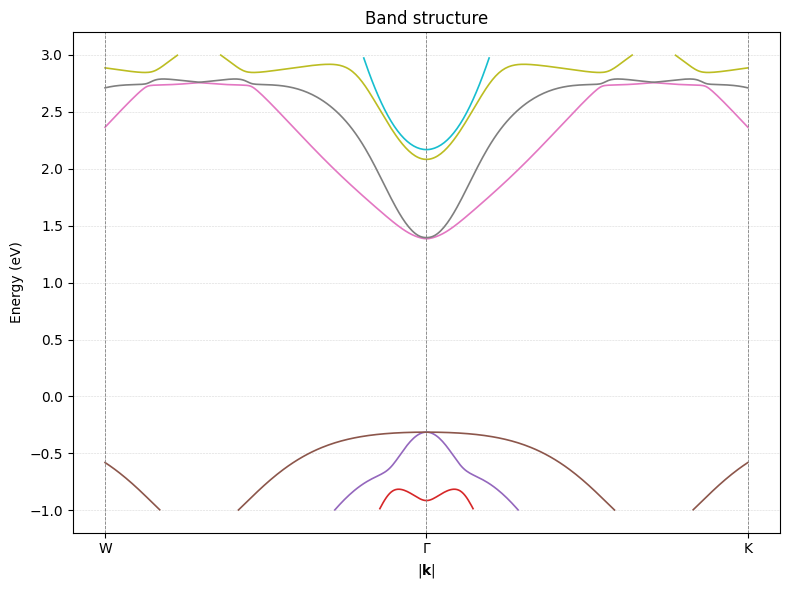

In [37]:
import numpy as np
import matplotlib.pyplot as plt


class BandStructurePlotter:

   
    def __init__(self, N: int, potential_profile: np.ndarray= None):
        self.N = N
        if potential_profile is None:
            self.V = np.asarray(potential_profile)
        
        self.k_path = None
        self.k_ticks = None      
        self.energies = None    

    # k space
    @staticmethod
    def _cumulative_distance(k_path):
        d = np.zeros(len(k_path))
        for i in range(1, len(k_path)):
            d[i] = d[i-1] + np.linalg.norm(k_path[i] - k_path[i-1])
        return d

    @staticmethod
    def _segment(a, b, n):
        """n points from a→b (excluding b)."""
        return np.linspace(a, b, n, endpoint=False)

    def build_k_path(self, corner_points, points_per_segment=200):
        """
        corner_points : list of 3-vectors (in Cartesian reciprocal space)
            e.g. [W, Γ, K, …].
        """
        k = []
        for p, q in zip(corner_points[:-1], corner_points[1:]):
            k.extend(self._segment(p, q, points_per_segment))
        k.append(corner_points[-1])          # include the last corner exactly
        self.k_path = np.array(k)
        self.k_ticks = {lbl: i*points_per_segment
                        for i, lbl in enumerate("".join((" " * (len(corner_points)-1))).split())}

    #eigen states
    def _compute_band_structure(self):
        assert self.k_path is not None, "call build_k_path() first"
        Nk = len(self.k_path)
        # get one eigen-spectrum just to know how many bands
        test_E = create_tight_binding(self.k_path[0], self.N)[0]
        Nb = test_E.size
        self.energies = np.empty((Nk, Nb))
        for i, kvec in enumerate(self.k_path):
            self.energies[i] = np.sort(create_tight_binding(kvec, self.N)[0].real)

    # plot
    def plot(self, energy_window=None, colour_cycle=None,
             k_labels=None, linewidth=1.2, figsize=(8, 6)):
        """
        energy_window : (Emin, Emax) tuple or None
            Energies outside are masked out (useful to hide surface bands).
        k_labels : dict {label: index} or None
            Override tick labels.  If None, W-Γ-K… order is auto-generated.
        """
        if self.energies is None:
            self._compute_band_structure()

        # x-axis
        k_x = self._cumulative_distance(self.k_path)

        # optional masking
        E = self.energies.copy()
        if energy_window is not None:
            Emin, Emax = energy_window
            E[(E < Emin) | (E > Emax)] = np.nan

        # plotting
        plt.figure(figsize=figsize)
        if colour_cycle:
            plt.gca().set_prop_cycle(color=colour_cycle)

        for band in range(E.shape[1]):
            plt.plot(k_x, E[:, band], lw=linewidth)

        # decorations
        plt.ylabel("Energy (eV)")
        plt.xlabel("$|\\mathbf{k}|$")
        plt.title("Band structure")
        plt.grid(True, ls="--", lw=0.4, alpha=0.5)

        # ticks at high-symmetry points
        if k_labels is None and self.k_ticks:
            k_labels = self.k_ticks
        if k_labels:
            tick_pos = [k_x[idx] for idx in k_labels.values()]
            for x in tick_pos:
                plt.axvline(x, color='grey', ls='--', lw=0.6)
            plt.xticks(tick_pos, list(k_labels.keys()))

        plt.tight_layout()
        plt.show()
# high symmetry points
a = 1.0
G  = np.array([0, 0])
K  = np.array([-1/2, 0])
W  =np.array([1/2,0])

# plot
N  = 2
plotter = BandStructurePlotter(N)
plotter.build_k_path([W, G, K], points_per_segment=200)

# custom tick dictionary (same indices you used before)
plotter.plot(energy_window=(-1, 3),
             k_labels={'W': 0,
                       r'$\Gamma$': 200,
                       'K': 400})


In [38]:
import numpy as np
from itertools import product
from multiprocessing import Pool, cpu_count

# create the k grid 
def make_mp_grid(Nk):
    """Return an (Nk3, 3) array of fractional k-vectors (0 … 1) in the 1st BZ."""
    shifts = np.linspace(0, 1, Nk, endpoint=True) + 0.5/Nk   
    klist  = np.array(list(product(shifts, repeat=2)))        

    return klist                                             

def analyzeRange(energies):
    largest_diff = [0,1,abs(energies[1] - energies[0])]
    for i,val in enumerate(energies[:-1]):
        diff = val - energies[i + 1]
        if abs(diff) > largest_diff[-1]:
            largest_diff[0] = i
            largest_diff[1] = i + 1
            largest_diff[-1] = abs(diff)
    
    return largest_diff[-1] + largest_diff[-1], 10
# helper method 
def frac_shift(k_frac, delta):
    return (k_frac + delta) % 1.0

#  effective-mass tensor around the CBM
def find_effective_mass(N, k_min_frac, Nk_coarse, band_idx,
                        resolution_factor=4, a=5.431e-10):


    delta_frac = 1.0 / (Nk_coarse * resolution_factor)        # we want a finer mesh size
    dk = (2*np.pi / a) * delta_frac                       


    k0 = np.asarray(k_min_frac, float)

    # get the good energy
    def E(k_frac):
        evs, _ = create_tight_binding(k_frac, N)
        energyTosend = evs[band_idx]
        print(energyTosend)
        
        return energyTosend
        

    #shift 
    ei = np.eye(2)

    # Hessian 
    H = np.zeros((2,2))
    for i in range(2):
        # second derivative along axis i
        kp = frac_shift(k0,  +delta_frac * ei[i])
        km = frac_shift(k0,  -delta_frac * ei[i])
        H[i,i] = (E(kp) + E(km) - 2*E(k0)) / dk**2

        # mixed derivatives
        for j in range(i+1, 2):
            kpp = frac_shift(k0, +delta_frac*ei[i] + delta_frac*ei[j])
            kmm = frac_shift(k0, -delta_frac*ei[i] - delta_frac*ei[j])
            kpm = frac_shift(k0, +delta_frac*ei[i] - delta_frac*ei[j])
            kmp = frac_shift(k0, -delta_frac*ei[i] + delta_frac*ei[j])
            H[i,j] = H[j,i] = (E(kpp)+E(kmm)-E(kpm)-E(kmp)) / (4*dk**2)

    # convert eV → J
    H_J = H * spc.e

    # m*  = hbar^2 *
    mstar_SI = spc.hbar**2 * np.linalg.inv(H_J)           # kg
    mstar_me = mstar_SI / spc.m_e                         # in m_e

    prin_m, prin_axes = np.linalg.eigh(mstar_me)
    return mstar_me, prin_m, prin_axes
N =2
def eval_k(k_frac):
    """return the good eigenvalues"""
    eigvals, _ = create_tight_binding(k_frac, N)    
    vbm = eigvals[eigvals <=  0.0].max()     
    cbm = eigvals[eigvals >=  0.0].min()
    return vbm, cbm, eigvals
def scan_full_BZ(self,Nk=20, store_all=True, n_jobs=None, a=5.431e-10,
                 res_factor=4):
    """
    Nk       : number of k-points per reciprocal-lattice axis (Nk³ total)
    store_all: if True, return the entire E(k) array (size Nk³ × Nb)
    n_jobs   : cores to use; default = all available
    """
 
    klist = make_mp_grid(Nk)
    nbands = len(create_tight_binding(np.zeros(2), N)[0])   # quick probe
    
    dk = 1 / Nk
    # ----- parallel diagonalisation -----
    n_jobs = n_jobs or cpu_count()
    with Pool(processes=n_jobs) as pool:
        results = pool.map(eval_k, klist, chunksize=len(klist)//n_jobs)

    # collect extrema
    vbm_E, cbm_E = -np.inf, np.inf
    vbm_data = cbm_data = None
    if store_all:
        all_E = np.empty((len(klist), nbands))
      

    for idx, (v, c, eigs) in enumerate(results):
        if v > vbm_E:
            vbm_E      = v
            vbm_data   = (v, klist[idx], int(np.where(eigs==v)[0][0]))
        if c < cbm_E:
            
            cbm_E      = c
            cbm_data   = (c, klist[idx], int(np.where(eigs==c)[0][0]))
        if store_all:
            all_E[idx] = eigs

    
    
    
    Egap = cbm_E - vbm_E
    print(f"Fundamental gap = {Egap:.4f} eV")
    print("VBM : E = {:.4f} eV  at k_frac = {}".format(*vbm_data[:2]))
    print("CBM : E = {:.4f} eV  at k_frac = {}".format(*cbm_data[:2]))
    print("Direct gap" if np.allclose(vbm_data[1], cbm_data[1]) else "Indirect gap")
    mstar, prin_m, prin_ax = find_effective_mass(N, cbm_data[1], Nk,
                                                 cbm_data[2],
                                                 resolution_factor=res_factor,
                                                 a=a)
    print("\nEffective-mass tensor at CBM:\n", mstar)
    print("Principal masses:\n", prin_m)

    if store_all:
        return (Egap, vbm_data, cbm_data,
                klist, all_E,
                mstar, prin_m, prin_ax)
    return Egap, vbm_data, cbm_data, mstar, prin_m, prin_ax


Egap, vbm, cbm, klist, allE, M, m_prin, axes = scan_full_BZ(2, Nk=41, store_all=True, res_factor=6)

print("\ndelta-valley:  m_l = {:.3f}  m_t = {:.3f}  (in me)".format(m_prin.max(), m_prin.min()))



Fundamental gap = 1.7071 eV
VBM : E = -0.3168 eV  at k_frac = [0.71219512 0.71219512]
CBM : E = 1.3903 eV  at k_frac = [0.71219512 0.71219512]
Direct gap
1.3957694448400317
1.3877333691284197
1.3903294150699004
1.402035823560746
1.3852891344057154
1.3928583712533074
1.3928583712533138
1.3957694448400286
1.3877333691284242
1.3903294150699004

Effective-mass tensor at CBM:
 [[ 0.06046767 -0.00854831]
 [-0.00854831  0.06046767]]
Principal masses:
 [0.05191936 0.06901598]

delta-valley:  m_l = 0.069  m_t = 0.052  (in me)


In [9]:
# broken 

def getTheDOS(E, N, sigma):
    def gaussian(En):
        return 1 / np.sqrt(2 * np.pi * sigma) * np.exp(-(E - En)**2 / (2 * sigma))
    D = 0
    for kx in np.linspace(-1,1,50):
        kx = 2 *np.pi / a * kx
        for ky in np.linspace(-1,1,50):
                energies = create_tight_binding(np.array([kx, ky, 0]), N, potentialProfile)[0]
                for en in energies:
                    D += gaussian(en)
            
    
    return D
        

def getFermiLevel(N, dos, dosE):
    kbT = 0.0257   
    fermi = lambda x: 1.0 / (1.0 + np.exp(x / kbT))
    
    def integralGuess(x):
        dE = dosE[1] - dosE[0]
    
        occupancy = fermi(dosE - x)  
    
        return dE * np.sum(dos * occupancy)
    
    numberOfElectrons = 4 * N * 8

    E_F = 0.55
    err = integralGuess(E_F) - numberOfElectrons

    step = 0.01
    while abs(err) > 2.0:
        if err < 0:

            E_F -= step
        else:
            E_F += step
        
        err = integralGuess(E_F) - numberOfElectrons
    
    return E_F

    

In [10]:
# test code for DOS
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as spc

hbar = 1       
m    = 1
q    = 1
L    = 1
Ec = 1 

Lz   = 20         

Nk = 40000

k = np.linspace(-np.pi / L, np.pi / L, Nk)
Ek = hbar**2 * k**2 / (2 * m) + Ec          # dispersion

sigma = .001
E = np.linspace(Ek.min(), Ek.max(), 1000)    # energy axis
dos = np.sum(np.exp(-(E[:, None] - Ek[None, :])**2 / (2 * sigma**2)), axis=1)
dos /= np.sqrt(2 * np.pi) * sigma      # normalize Gaussians
realdos = m * L / hbar / np.pi * np.sqrt((1 / (2 * m * (E - Ec))))




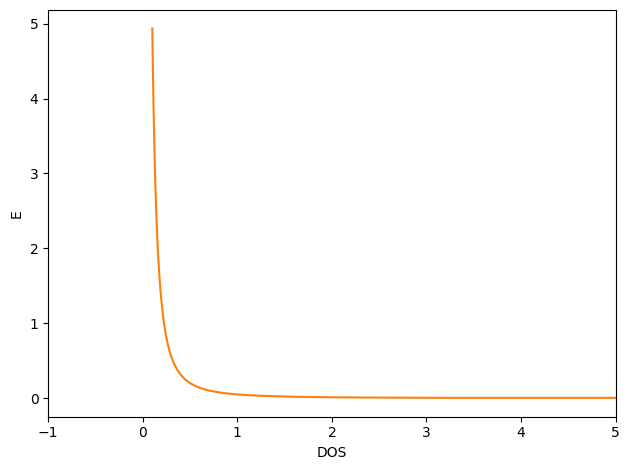

In [11]:
#print(dos)
plt.plot(dos, (E - Ec)/q)


plt.plot(realdos, (E - Ec)/q)
plt.xlabel('DOS')
plt.xlim((-1,5))
plt.ylabel('E')
plt.tight_layout()
plt.show()

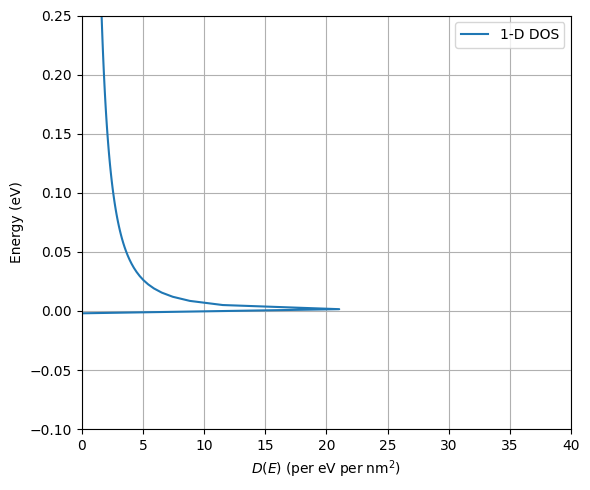

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --- physical constants (SI; energies stay in eV) ---
hbar = 1.055e-34       # J·s
m    = 9.110e-31       # kg
q    = 1.602e-19       # C   (eV → J conversion factor)
L    = 1e-9            # 1 nm in m


Lz   = 20e-9           # m   (set 5e‑9 for case (a))

# sub‑band spacing
E0 = (hbar**2 * np.pi**2) / (2 * q * m * Lz**2)   # eV

# energy axis (eV)
E = np.linspace(-0.1, 0.25, 101)

# Heaviside steps θ(E) and θ(E – E_p)
theta_E  = (E > 0).astype(float)                  # θ(E)
D2       = np.zeros_like(E)                       # initialise 2‑D DOS accumulator

for p in range(1, 26):                            # p = 1 … 25
    EE       = E - (p * p * E0)
    theta_EE = (EE > 0).astype(float)             # θ(E – E_p)

    # 1‑D, 2‑D, 3‑D DOS (1‑D term D1 is unused later but shown for completeness)
    D1 = np.zeros_like(E)
    mask = E > 0                      # avoid E = 0 exactly
    D1[mask] = (L * q * m /
                (np.pi * hbar) *
                (2 * m * q * E[mask])**(-0.5))

    D2 += (L**2 * q * m * theta_EE) / (2 * np.pi * hbar**2)

    if p == 25:                                   # save last‑pass 3‑D term
        D3 = (L**3 * q * m * theta_E /
               (2 * np.pi**2 * hbar**3) *
               np.sqrt(2 * m * q * np.maximum(E, 0)))

# --- plotting (matches MATLAB order: x = DOS, y = E) ---
plt.figure(figsize=(6, 5))
plt.plot(D1,              E, label="1‑D DOS", linewidth=1.5)
#plt.plot(D3 * Lz / L,     E, label="3‑D DOS × (Lz/L)", linewidth=1.5)

plt.xlim(0, 40)           # part (b) limits; use (0,10) for part (a)
plt.ylim(-0.1, 0.25)
plt.xlabel(r"$D(E)\;(\mathrm{per\;eV\;per\;nm^2})$")
plt.ylabel("Energy (eV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:



def getFermiLevel(N, dos, dosE):
    kbT = 0.0257   
    fermi = lambda x: 1.0 / (1.0 + np.exp(x / kbT))
    
    def integralGuess(x):
        dE = dosE[1] - dosE[0]
    
        occupancy = fermi(dosE - x)  
    
        return dE * np.sum(dos * occupancy)
    
    numberOfElectrons = 1

    E_F = 0.55
    err = integralGuess(E_F) - numberOfElectrons

    step = 0.01
    while abs(err) > 2.0:
        if err < 0:

            E_F -= step
        else:
            E_F += step
        
        err = integralGuess(E_F) - numberOfElectrons
    
    return E_F



In [14]:
 
energies = np.linspace(-1,1, 501)
def getFermiLevel(N, dos, dosE):
    kbT = 0.0257   
    fermi = lambda x: 1.0 / (1.0 + np.exp(x / kbT))
    
    def integralGuess(x):
        dE = dosE[1] - dosE[0]
    
        occupancy = fermi(dosE - x)  
    
        return dE * np.sum(dos * occupancy)
    
    numberOfElectrons = 1

    E_F = 0.55
    err = integralGuess(E_F) - numberOfElectrons

    step = 0.01
    while abs(err) > 2.0:
        if err < 0:

            E_F -= step
        else:
            E_F += step
        
        err = integralGuess(E_F) - numberOfElectrons
    
    return E_F

### old sp3

In [15]:

def create_tight_binding(k, N, potentialProfile):
    kx,ky,kz = k
    unitCell = UnitCellGeneration(N)
    unitNeighbors = unitCell.neighborTable()
    numSilicon = len(unitNeighbors.keys())
    size = numSilicon* 4 # sp3
    A = np.zeros((size, size), dtype=complex)    
    
    atomToIndex = {}
    indexToAtom = {}
    for atom_index,atom in enumerate(unitNeighbors):
        atomToIndex[atom] = atom_index
        indexToAtom[atom_index] = atom
    
  
    orbitals = ['s', 'px', 'py', 'pz']
    
    # old code with no dangling bonds 
    """for atom_index in range(numSilicon):
        for orbIndex, orbital in enumerate(orbitals):
            index = atom_index * 4 + orbIndex
            #print(orbital)
            A[index, index] += E[orbital]"""

            
    for atom_idx, atom in indexToAtom.items():
        hybridizationMatrix = H_sp3_explicit.copy() 

        for delta in unitCell.dangling_bonds(atom):
            signs = np.array([1/4] + list(delta)) * 4
            h = UnitCellGeneration.determine_hybridization(signs)
            hybridizationMatrix[h, h] += E['sp3']          # increase the energy of dangling states 
        
        # if there are no dangling bonds this returns the standard diag matrix with onsite energies 
        onsiteMatrix = U_orb_to_sp3 @ hybridizationMatrix @ U_orb_to_sp3.T # go back to orbital basis 
        A[atom_idx*4:(atom_idx+1)*4, atom_idx*4:(atom_idx+1)*4] = onsiteMatrix
    
    for atom_index in range(numSilicon):
        atom = indexToAtom[atom_index]
        neighbors = unitNeighbors[atom]
        for orbitalIndex, orbital in enumerate(orbitals):
            index_i = atom_index * 4 + orbitalIndex
            
            effectiveZinPotential = int(atom.z)
            
            A[index_i,index_i] += potentialProfile[effectiveZinPotential]
            
            for neighbor in neighbors.keys():
                delta = neighbors[neighbor][0]
                l,m,n = neighbors[neighbor][1:]
                phase = np.exp(1j * (kx*delta[0] + ky*delta[1])) # blochs theorem does not work 
                
                neighbor_index = atomToIndex[neighbor]       
                
                for secOrbitalIndex, secondOrbital in enumerate(orbitals):
                    index_j = neighbor_index * 4 + secOrbitalIndex
                    
                    hop = SK[(orbital, secondOrbital)](l, m, n, V)
                        
                    A[index_i,index_j] += hop * phase   
            
                
        dagger = lambda A: np.conjugate(A.T)
    if not np.allclose(A, dagger(A)):
        print("H isnt Hermitian")

    eigvals,eigv = np.linalg.eigh(A)
    return eigvals, eigv, A